In [1]:
import numpy as np
import scipy.stats as st
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as av
import pymc3 as pm
import theano as th
import theano.tensor as tt

Normal vs. Gumbel

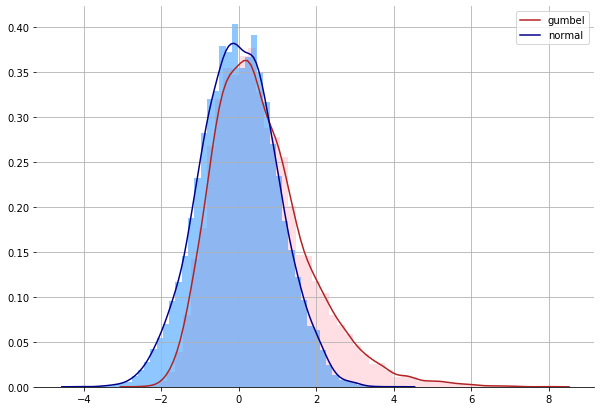

In [1730]:
dist = np.random.gumbel(size=10000)
dist2 = np.random.normal(size=10000)

plt.figure(figsize=(10, 7))
sns.distplot(dist, color='firebrick', hist=False, label='gumbel')
plt.hist(dist, bins=50, density=True, alpha = 0.5, color='pink')
sns.distplot(dist2, color='darkblue', hist=False, label='normal')
plt.hist(dist2, bins=50, density=True, alpha = 0.5, color='dodgerblue')

plt.grid(True)
sns.despine(left=True)
plt.legend(frameon=True)
plt.savefig("../../sidravi1.github.io/assets/20191110_normal_v_gumbel.png")

Difference between two utilities with Gumbel errors is logistic

In [1731]:
err1 = np.random.gumbel(size=10000)
err2 = np.random.gumbel(size=10000)

In [1732]:
err_diff = err1 - err2

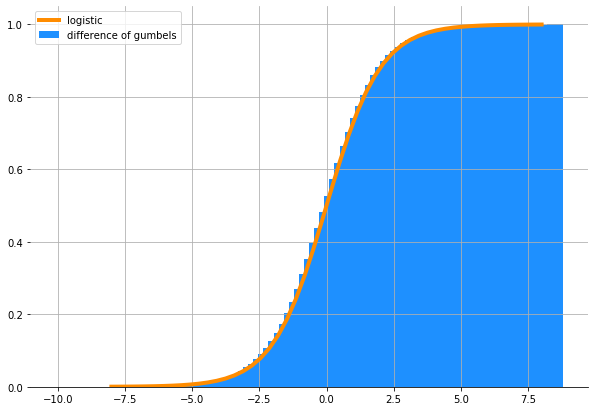

In [1744]:
a = np.linspace(-8, 8)
logistic = np.exp(a) / (1 + np.exp(a))
plt.figure(figsize=(10, 7))
plt.hist(err_diff, cumulative=True, bins=100, density=True, color='dodgerblue', label = "difference of gumbels")
plt.plot(a, logistic, lw=4, color='darkorange', label = "logistic")

plt.grid(True)
sns.despine(left=True)
plt.legend(frameon=True)
plt.savefig("../../sidravi1.github.io/assets/20191110_gumbel_logistic.png")

In [5]:
err3 = 5 * np.random.gumbel(size=10000)
np.var(err3), np.pi**2 * 5**2 / 6

(42.4298049425944, 41.12335167120566)

# 3.3 Power and Limitation of Logit

## 3.3.1 Taste Variation

$$
U_{nj} = \alpha_n {SR}_j + \beta_n{PP}_j + \epsilon_{nj}
$$

and

$$
\alpha_n = \rho M_n\\
\beta_n = \theta / I_n
$$

Substituting these into first equation:

$$
U_{nj} = \rho (M_n {SR}_j) + \theta ({PP}_j / I_n) + \epsilon_{nj}
$$

In [1756]:
def plot_results(trace, beta_true, ax=False, xlim = None):
    
    if ax is False:
        f, ax = plt.subplots(figsize=(7,10))
    ys = np.arange(beta_true.shape[0])
    xs_true = beta_true
    
    xs_pred_mean = trace.mean(axis=0)
    xs_pred_low, xs_pred_high = np.percentile(trace, q=[2.5, 97.5], axis=0)
    
    ax.plot(xs_true, ys, ".r", ms=10, label='actual')
    ax.hlines(ys, xmin=xs_pred_low, xmax=xs_pred_high, zorder=-1)
    ax.scatter(xs_pred_mean, ys, facecolors='lightblue', edgecolors='k', s=80, label='estimate')
    ax.set_yticks(np.arange(0, len(beta_true) + 1))
    ax.axvline(x=0, ls=":")
    ax.set_ylabel("Betas")
    if xlim != None:
        ax.set_xlim(xlim)
    ax.legend(loc=2)
    
    ax.grid(True)
    plt.tight_layout()

    sns.despine(left=True)
    return ax

### When tastes change systematically

In [1229]:
n_cars = 3
n_households = 1000
n_params = 10

np.random.seed(33)
cars = np.random.normal(0, 2, size=(n_cars, n_params))
households = np.random.normal(0, 2, size=(n_households, n_params))

betas = np.random.normal(0, 1, size=n_params)

errors = np.random.gumbel(0, 2, size=(n_households, n_cars))

In [1232]:
utility = (betas * households) @ cars.T + errors

In [1233]:
#utility = utility - utility[0, 0]
choice = np.argmax(utility, axis=1)
choice

car_choice_simple = np.zeros_like(utility)
car_choice_simple[np.arange(car_choice_simple.shape[0]), choice] = 1

In [1234]:
cars_oo = cars - cars[0]

In [1181]:
with pm.Model() as m_simple:
    
    betas_rest = pm.Normal('betas', 0, 1, shape=(1, n_params))
    
    utility_ = tt.dot((betas_rest * households), cars_oo[1:].T)
    utility_zero = pm.Deterministic('utility', tt.concatenate([tt.zeros((n_households, 1)), utility_], axis=1))
    p = pm.Deterministic('p', tt.nnet.softmax(utility_zero))

    pm.Multinomial('ll', n=1, p=p, observed = car_choice_simple)
    

In [1182]:
trace = pm.sample(draws=500, model=m_simple, tune=5000, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:26<00:00, 816.93draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [ ]:
trace = pm.sample(draws=500, model=m_simple, tune=5000, target_accept=0.95)

scaled_trace = trace['betas'].squeeze()
scaled_trace = scaled_trace / scaled_trace[:, 0].reshape(-1, 1)
plot_results(scaled_trace, betas/betas[0], xlim = (-10, 15))
plt.savefig("../../sidravi1.github.io/assets/20191110_taste_variation.png")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas]
Sampling 4 chains:  42%|████▏     | 9254/22000 [00:22<00:30, 422.42draws/s]

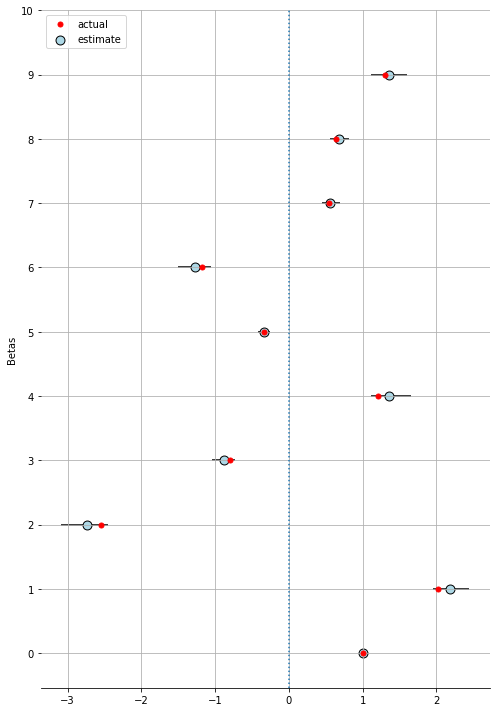

In [1757]:
ax = plot_results(scaled_trace, betas/betas[0])
plt.savefig("../../sidravi1.github.io/assets/20191110_taste_variation.png")

In [1306]:
pm.summary(trace, var_names = 'p')

/Users/sidravi/anaconda3/envs/experiments/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p__0_0,2.124711e-07,3.485411e-07,1.386925e-08,1.225972e-09,7.596487e-07,543.789917,1.001016
p__0_1,7.525262e-01,1.126923e-01,2.597561e-03,5.405707e-01,9.473197e-01,1981.794866,1.000812
p__0_2,2.474736e-01,1.126922e-01,2.597560e-03,5.268026e-02,4.594291e-01,1981.793405,1.000812
p__1_0,9.998868e-01,1.169009e-04,4.433430e-06,9.996839e-01,9.999961e-01,612.126867,1.000938
p__1_1,1.732020e-05,1.955470e-05,7.911611e-07,5.377585e-07,5.214826e-05,523.815549,1.000885
...,...,...,...,...,...,...,...
p__998_1,7.234737e-05,7.204203e-05,2.974967e-06,3.346345e-06,1.974416e-04,490.325524,1.001054
p__998_2,9.999276e-01,7.211852e-05,2.978198e-06,9.998024e-01,9.999967e-01,490.343991,1.001054
p__999_0,2.879577e-04,2.129304e-04,9.224533e-06,2.958912e-05,6.993629e-04,439.669237,1.002369
p__999_1,9.986286e-01,9.266690e-04,3.736087e-05,9.968125e-01,9.998526e-01,505.563651,1.001868


### When tastes change randomly

Same household and cars as before except tastes vary purely randomly (or with respect to unobserved variables).

$$
\begin{aligned}
\alpha_n &= \rho M_n + \mu_n\\
\beta_n &= \theta / I_n + \eta_n
\end{aligned}
$$

Substituting into utility function

$$
\begin{aligned}
U_{nj} &= \rho (M_n {SR}_j) + \mu_n {SR}_j + \theta ({PP}_j/I_n) + \eta_n {PP}_j + \epsilon_{nj}\\
U_{nj} &= \rho (M_n {SR}_j) + \theta ({PP}_j/I_n) + \tilde{\epsilon}_{nj}
\end{aligned}
$$

In [1285]:
taste_errors = np.random.normal(4, 4, size = (n_households, n_params))
utility = (betas * households + taste_errors) @ cars.T + errors

In [1286]:
#utility = utility - utility[0, 0]
choice = np.argmax(utility, axis=1)
choice

car_choice_random = np.zeros_like(utility)
car_choice_random[np.arange(car_choice_random.shape[0]), choice] = 1

In [1287]:
with pm.Model() as m_random_taste:
    
    betas_rest = pm.Normal('betas', 0, 1, shape=(1, n_params))
    
    error = pm.Normal('error', 0, 5, shape = (n_households, n_params))
    utility_ = tt.dot((betas_rest * households + error), cars_oo[1:].T)
    utility_zero = pm.Deterministic('utility', tt.concatenate([tt.zeros((n_households, 1)), utility_], axis=1))
    p = pm.Deterministic('p', tt.nnet.softmax(utility_zero))
    
    pm.Multinomial('ll', n=1, p=p, observed = car_choice_random)
    

In [1288]:
trace_random = pm.sample(draws=500, model=m_random_taste, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [error, betas]
Sampling 4 chains: 100%|██████████| 4000/4000 [03:39<00:00, 18.25draws/s]


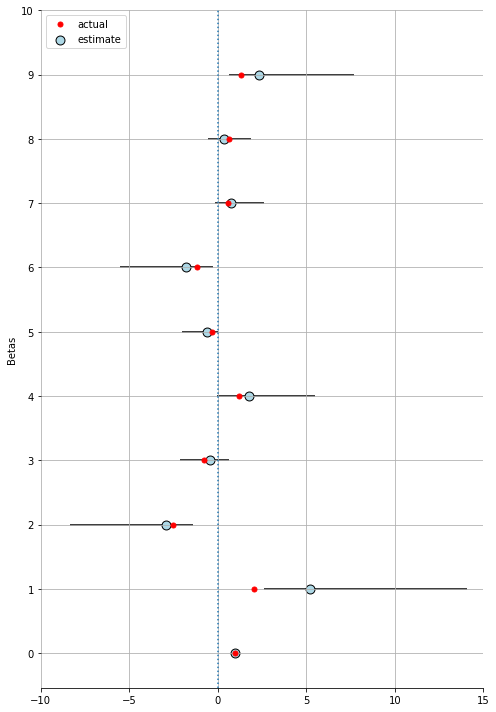

In [1761]:
scaled_trace = trace_random['betas'].squeeze()
scaled_trace = scaled_trace / scaled_trace[:, 0].reshape(-1, 1)
plot_results(scaled_trace, betas/betas[0], xlim = (-10, 15))
plt.savefig("../../sidravi1.github.io/assets/20191110_random_taste_error.png")

In [1290]:
with pm.Model() as m_random_taste2:
    
    betas_rest = pm.Normal('betas', 0, 1, shape=(1, n_params))

    utility_ = tt.dot((betas_rest * households), cars_oo[1:].T)
    utility_zero = pm.Deterministic('utility', tt.concatenate([tt.zeros((n_households, 1)), utility_], axis=1))
    p = pm.Deterministic('p', tt.nnet.softmax(utility_zero))
    
    pm.Multinomial('ll', n=1, p=p, observed = car_choice_random)
    

In [1291]:
trace_random2 = pm.sample(draws=500, model=m_random_taste2, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:04<00:00, 922.53draws/s] 


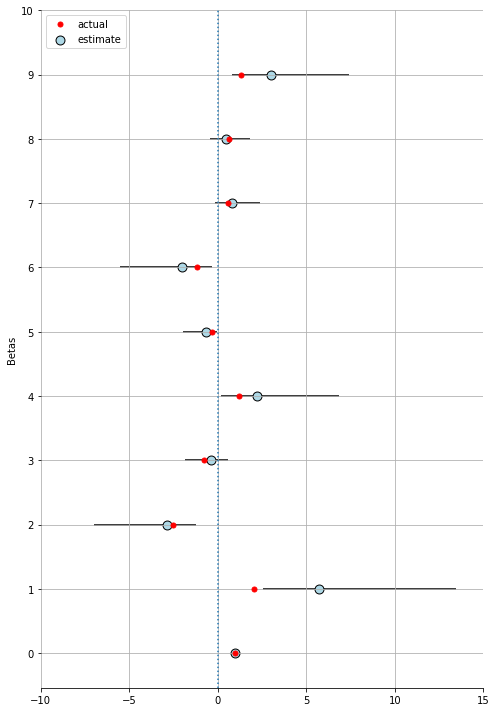

In [1760]:
scaled_trace = trace_random2['betas'].squeeze()
scaled_trace = scaled_trace / scaled_trace[:, 0].reshape(-1, 1)
plot_results(scaled_trace, betas/betas[0], xlim = (-10, 15))
plt.savefig("../../sidravi1.github.io/assets/20191110_random_taste.png")

## 3.3.2 Substitution Patterns

### Independence from Irrelevent Alternatives

In [1620]:
utility = [6, 8, 4]
p = sp.special.softmax(utility)
p

array([0.11731043, 0.86681333, 0.01587624])

In [1621]:
utility1 = [6 * 1.2, 8, 4]
p1 = sp.special.softmax(utility1)
p1

array([0.30615652, 0.68136387, 0.01247961])

In [1622]:
diff = p1 - p
diff

array([ 0.18884609, -0.18544947, -0.00339663])

In [1623]:
diff[0] * p[1]/(p[1] + p[2])

0.18544946661853565

In [1624]:
utility = (betas * households) @ cars.T + errors
p_base = sp.special.softmax(utility, axis=1)

In [1633]:
p_base_ratio_12 = np.log(p_base[:, 1]) - np.log(p_base[:, 2])

In [1629]:
cars_0_improved = cars.copy()
cars_0_improved[0] = cars_0_improved[0] * 2

utility_car0_imp = (betas * households) @ cars_0_improved.T + errors
p_car0_imp = sp.special.softmax(utility_car0_imp, axis=1)

In [1636]:
p_car0imp_diff12 = np.log(p_car0_imp[:, 1]) / np.log(p_car0_imp[:, 2])

In [1637]:
np.all(np.isclose(p_car0imp_ratio_12, p_base_ratio_12))

True

### Proportional substituion

In [1640]:
diff_imp_car0 = p_car0_imp[:, 0] - p_base[:, 0]

In [1673]:
diff_imp_car1_prop = diff_imp_car0 * p_base[:, 1]/(p_base[:, 1] + p_base[:, 2])

In [1674]:
diff_imp_car1 = p_base[:, 1] - p_car0_imp[:, 1]

array([-7.02909952e-15,  1.64137436e-08, -5.61159328e-20, ...,
        3.04971680e-02,  0.00000000e+00, -3.34555540e-07])

In [1675]:
diff_imp_car1_prop

array([-7.02886651e-15,  1.64137436e-08, -5.61378103e-20, ...,
        3.04971680e-02, -3.95028191e-24, -3.34555540e-07])

In [1676]:
np.all(np.isclose(diff_imp_car1_prop, diff_imp_car1))

True